<a href="https://colab.research.google.com/github/pietroottana/finance-portfolio/blob/main/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [279]:
from __future__ import annotations

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [280]:
def to_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
  rets = np.log(prices / prices.shift(1))
  return rets.dropna()

In [281]:
def download_prices(tickers: list[str], start: str = "2017-01-01", end: str | None = None):
  data = yf.download([t.upper() for t in tickers], start=start, end=end, auto_adjust=True, progress=False)["Close"]
  if isinstance(data, pd.Series):
    data = data.to_frame()
  data = data.ffill().dropna(how="any")
  data.columns = [c.upper() for c in data.columns]
  return data

In [282]:
def quick_summary(prices: pd.DataFrame, returns: pd.DataFrame):
  print("=== PRICES (tail) ===")
  print(prices.tail())
  print("=== RETURNS (daily log, describe) ===")
  print(returns.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

In [283]:
def plot_prices(prices: pd.DataFrame, title: str = "Prices") -> None:
  plt.figure(figsize=(10,4))
  for c in prices.columns:
    plt.plot(prices.index, prices[c], label=c)
  plt.title(title)
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend(ncol=3)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [284]:
def plot_return_hist(returns: pd.DataFrame, title: str = "Daily log-returns (hist)") -> None:
  plt.figure(figsize=(10,4))
  returns.plot(kind="hist", bins=80, alpha=0.5, figsize=(10,4))
  plt.title(title)
  plt.xlabel("Return")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

=== PRICES (tail) ===
                  AAPL       GOOGL        MSFT        NVDA
Date                                                      
2025-11-10  269.429993  290.100006  506.000000  199.050003
2025-11-11  275.250000  291.309998  508.679993  193.160004
2025-11-12  273.470001  286.709991  511.140015  193.800003
2025-11-13  272.950012  278.570007  503.290009  186.860001
2025-11-14  272.410004  276.410004  510.179993  190.169998
=== RETURNS (daily log, describe) ===
              AAPL        GOOGL         MSFT         NVDA
count  1728.000000  1728.000000  1728.000000  1728.000000
mean      0.001147     0.000963     0.000974     0.002333
std       0.019691     0.019770     0.017950     0.032519
min      -0.137708    -0.123685    -0.159454    -0.203980
1%       -0.052658    -0.052786    -0.044676    -0.080366
5%       -0.030248    -0.030207    -0.027332    -0.048497
50%       0.001368     0.001523     0.001160     0.003192
95%       0.029764     0.030015     0.026134     0.051568
99%  

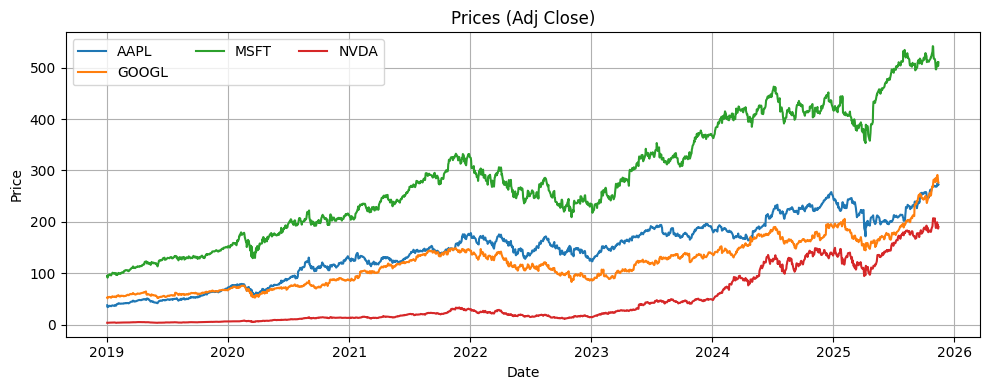

<Figure size 1000x400 with 0 Axes>

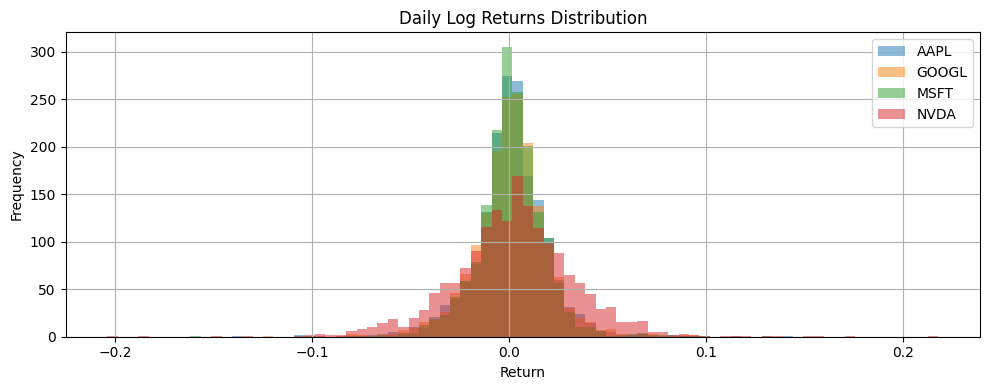

In [285]:
if __name__ == "__main__":
  TICKERS = ["AAPL", "MSFT", "GOOGL", "NVDA"] #Chose Tech US as example
  START = "2019-01-01"
  END = None # until today


print("Downloading Data...")
prices = download_prices(TICKERS, start=START, end=END)
rets = to_log_returns(prices)


# Sanity checks
assert prices.notna().all().all()
assert rets.notna().all().all()

#Results Summary
quick_summary(prices, rets)


# Graphs
plot_prices(prices, title="Prices (Adj Close)")
plot_return_hist(rets, title="Daily Log Returns Distribution")




In [286]:
try:
  from sklearn.covariance import LedoitWolf
  _HAS_SKLEARN = True
except Exception:
  _HAS_SKLEARN = False

In [287]:
try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception:
    _HAS_CVXPY = False

In [288]:
def to_log_returns(prices: pd.DataFrame):
  rets = np.log(prices / prices.shift(1))
  return rets.dropna()

In [289]:
def annualize_cov(cov: pd.DataFrame | np.ndarray, periods_per_year: int = 252) -> pd.DataFrame:
  return cov * periods_per_year

In [290]:
def corr_from_cov(cov: pd.DataFrame) -> pd.DataFrame:
  d = np.sqrt(np.diag(cov))
  D = np.outer(d, d)
  corr = cov.values / (D + 1e-12)
  return pd.DataFrame(corr, index=cov.index, columns=cov.columns)

In [291]:
def download_prices(tickers: list[str], start: str = "2019-01-01", end: str | None = None):
  data = yf.download([t.upper() for t in tickers], start=start, end=end, auto_adjust=True, progress=False)["Close"]
  if isinstance(data, pd.Series):
    data = data.to_frame()
  data = data.ffill().dropna(how="any")
  data.columns = [c.upper() for c in data.columns]
  return data

In [292]:
def cov_sample(returns: pd.DataFrame):
  return returns.cov()

In [293]:
def cov_ledoit_wolf(returns: pd.DataFrame):
  if not _HAS_SKLEARN:
    raise RuntimeError("scikit-learn non installato: pip install scikit-learn")
  lw = LedoitWolf().fit(returns.values)
  cov = pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns)
  return cov

In [294]:
def print_cov_stats(name: str, cov_daily: pd.DataFrame) -> None:
  eigvals = np.linalg.eigvalsh(cov_daily.values)
  cond = (eigvals.max() / (eigvals.min() + 1e-12))
  print(f"[{name}] — daily covariance")
  print(cov_daily.round(6))
  print(f"eig min/max: {eigvals.min():.6e} / {eigvals.max():.6e} | condition ≈ {cond:.2e}")

In [295]:
def plot_corr_heatmap(corr: pd.DataFrame, title: str = "Correlation heatmap") -> None:
  fig, ax = plt.subplots(figsize=(6,5))
  im = ax.imshow(corr.values, vmin=-1, vmax=1)
  ax.set_xticks(range(len(corr.columns)))
  ax.set_yticks(range(len(corr.index)))
  ax.set_xticklabels(corr.columns, rotation=45, ha='right')
  ax.set_yticklabels(corr.index)
  ax.set_title(title)
  fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
  fig.tight_layout()
  plt.show()

In [296]:
def plot_rolling_vol(returns: pd.DataFrame, window: int = 21, title: str = "Rolling annualized vol") -> None:
  roll_vol = returns.rolling(window).std() * np.sqrt(252)
  plt.figure(figsize=(10,4))
  for c in returns.columns:
    plt.plot(roll_vol.index, roll_vol[c], label=c)
  plt.title(f"{title} (window={window})")
  plt.xlabel("Date")
  plt.ylabel("Volatility")
  plt.legend(ncol=3)
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [297]:
def plot_rolling_corr(returns: pd.DataFrame, pair: tuple[str,str], window: int = 63,
  title: str | None = None) -> None:
  a, b = pair
  series = returns[[a, b]].rolling(window).corr().unstack().iloc[:,1]
  plt.figure(figsize=(10,3.8))
  plt.plot(series.index, series.values)
  plt.axhline(0, linewidth=1)
  plt.title(title or f"Rolling correlation {a}-{b} (window={window})")
  plt.xlabel("Date")
  plt.ylabel("Correlation")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [298]:
if __name__ == "__main__":
  TICKERS = ["AAPL", "MSFT", "GOOGL", "NVDA"]
  START = "2019-01-01"
  END = None


print("Scarico i dati...")
prices = download_prices(TICKERS, start=START, end=END)
rets = to_log_returns(prices)


# Stime giornaliere
cov_s = cov_sample(rets)
corr_s = corr_from_cov(cov_s)


print_cov_stats("Sample", cov_s)


# Prova anche Ledoit–Wolf se disponibile
if _HAS_SKLEARN:
  cov_lw = cov_ledoit_wolf(rets)
  corr_lw = corr_from_cov(cov_lw)
  print_cov_stats("Ledoit–Wolf", cov_lw)
  # Differenza Frobenius per farsi un'idea di quanto shrinka
  frob = np.linalg.norm(cov_s.values - cov_lw.values, ord='fro')

  print(f"||Sample - LW||_F = {frob:.6e}")

else:
  print("(scikit-learn non trovato: salto Ledoit–Wolf)")
  cov_lw, corr_lw = None, None

Scarico i dati...
[Sample] — daily covariance
           AAPL     GOOGL      MSFT      NVDA
AAPL   0.000388  0.000242  0.000250  0.000374
GOOGL  0.000242  0.000391  0.000251  0.000369
MSFT   0.000250  0.000251  0.000322  0.000393
NVDA   0.000374  0.000369  0.000393  0.001058
eig min/max: 8.667120e-05 / 1.622851e-03 | condition ≈ 1.87e+01
[Ledoit–Wolf] — daily covariance
           AAPL     GOOGL      MSFT      NVDA
AAPL   0.000389  0.000240  0.000247  0.000371
GOOGL  0.000240  0.000392  0.000249  0.000366
MSFT   0.000247  0.000249  0.000324  0.000389
NVDA   0.000371  0.000366  0.000389  0.001052
eig min/max: 9.068066e-05 / 1.612201e-03 | condition ≈ 1.78e+01
||Sample - LW||_F = 1.204615e-05


Sample covariance (annualized) — valori principali:
           AAPL     GOOGL      MSFT      NVDA
AAPL   0.097704  0.061102  0.062904  0.094266
GOOGL  0.061102  0.098495  0.063241  0.093004
MSFT   0.062904  0.063241  0.081196  0.098930
NVDA   0.094266  0.093004  0.098930  0.266493


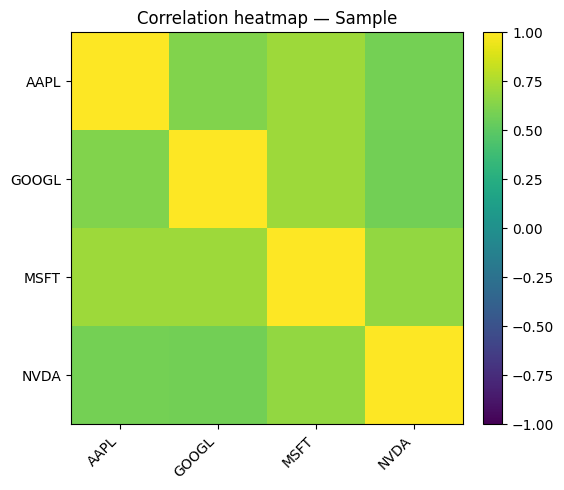

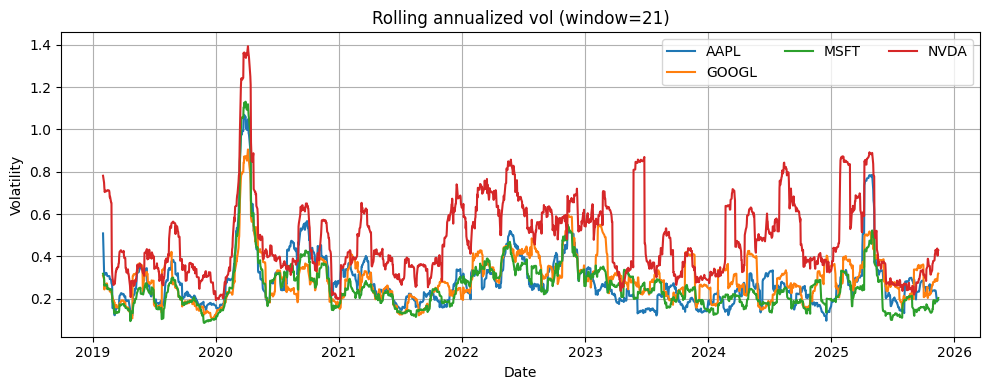

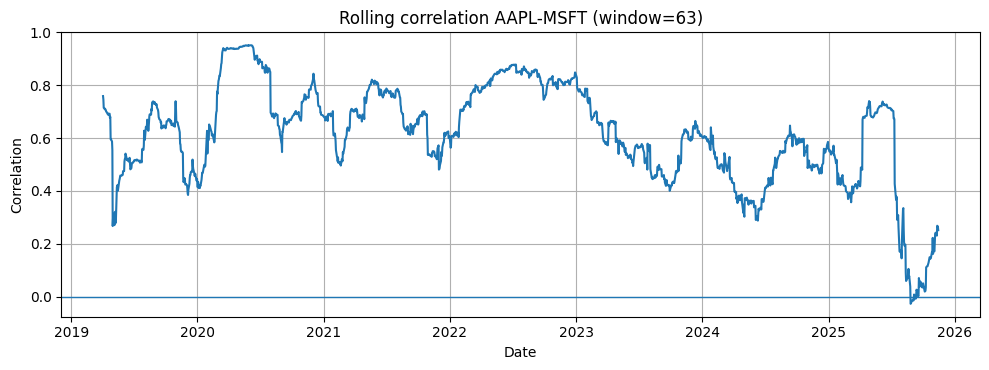

In [299]:
cov_s_ann = annualize_cov(cov_s)
print("Sample covariance (annualized) — valori principali:")
print(cov_s_ann.round(6))

# Plot: correlazioni attuali
plot_corr_heatmap(corr_s, title="Correlation heatmap — Sample")

# Plot: vol rolling (21g ≈ 1 mese) e una correlazione rolling esemplificativa
plot_rolling_vol(rets, window=21)
if len(TICKERS) >= 2:
  pair = (TICKERS[0].upper(), TICKERS[1].upper())
  plot_rolling_corr(rets, pair=pair, window=63)

In [300]:
def equal_weight(n: int) -> np.ndarray:
  return np.ones(n) / n

In [301]:
def annualize_returns(returns: pd.DataFrame | pd.Series, periods_per_year: int = 252):
    return returns.mean() * periods_per_year

In [302]:
def mean_variance_max_sharpe(mu_ann: np.ndarray, Sigma_ann: np.ndarray, rf: float = 0.0, long_only: bool = True, w_max: float | None = None) -> np.ndarray:
  if not _HAS_CVXPY:
    raise RuntimeError("CVXPY non installato: pip install cvxpy")
  n = len(mu_ann)
  w = cp.Variable(n)
  mu_ex = mu_ann - rf
  Sigma_psd = (Sigma_ann + Sigma_ann.T) / 2
  constraints = [cp.sum(w) == 1, cp.quad_form(w, Sigma_psd) <= 1.0]
  if long_only:
    constraints.append(w >= 0)
  if w_max is not None:
    constraints.append(w <= w_max)

  prob = cp.Problem(cp.Maximize(mu_ex @ w), constraints)
  prob.solve(solver=cp.SCS, verbose=False)
  if w.value is None:
    raise RuntimeError("Ottimizzazione Max Sharpe non riuscita")
  return np.array(w.value).reshape(-1)

In [303]:
def est_perf(mu_ann: pd.Series, Sigma_ann: pd.DataFrame, w: np.ndarray, rf: float = 0.0) -> dict:
  mu = float(mu_ann.values @ w)
  vol = float(np.sqrt(w @ Sigma_ann.values @ w))
  sharpe = (mu - rf) / (vol + 1e-12)
  return {"Ann.Return": mu, "Ann.Vol": vol, "Sharpe": sharpe}

In [304]:
def plot_weights_bar(weights: dict[str, pd.Series], title: str = "Weights comparison") -> None:
  # Stacking per confronto semplice
  all_names = list(next(iter(weights.values())).index)
  x = np.arange(len(all_names))
  width = 0.8 / len(weights)
  plt.figure(figsize=(10,4))
  for i, (name, w) in enumerate(weights.items()):
    plt.bar(x + i*width, w.values, width=width, label=name)
  plt.xticks(x + width*(len(weights)-1)/2, all_names, rotation=0)
  plt.ylabel("Weight")
  plt.title(title)
  plt.legend()
  plt.tight_layout()
  plt.show()

Scarico i dati...
 Pesi (Equal Weight):  AAPL     0.25
GOOGL    0.25
MSFT     0.25
NVDA     0.25
Name: EqualWeight, dtype: float64
Pesi (Max Sharpe):  AAPL     0.4
GOOGL   -0.0
MSFT    -0.0
NVDA     0.6
Name: MaxSharpe, dtype: float64
 Stime in-sample (annuali):               Ann.Return  Ann.Vol  Sharpe
EqualWeight      0.3412   0.3043  1.0557
MaxSharpe        0.4683   0.3949  1.1352


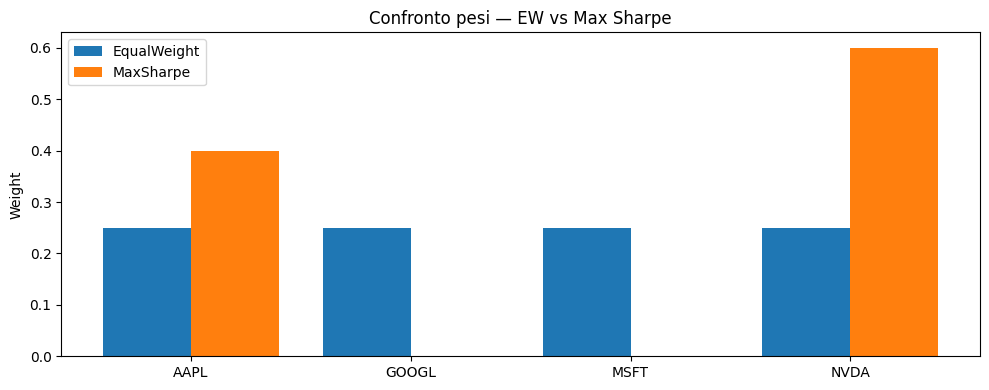

In [305]:
if __name__ == "__main__":
  # Universo (modificalo liberamente)
  TICKERS = ["AAPL", "MSFT", "GOOGL", "NVDA"]
  START = "2019-01-01"
  END = None


  RF_ANNUAL = 0.02 # es. 2% annuo
  LONG_ONLY = True
  W_MAX = 0.6 # cap opzionale per concentrazione


  print("Scarico i dati...")
  prices = download_prices(TICKERS, start=START, end=END)
  rets = to_log_returns(prices)


  # Stime base
  mu_ann = annualize_returns(rets)
  if _HAS_SKLEARN:
    Sigma_daily = cov_ledoit_wolf(rets)
  else:
    Sigma_daily = cov_sample(rets)

  Sigma_ann = annualize_cov(Sigma_daily)


  # Strategie
  w_eq = equal_weight(len(TICKERS))
  w_ms = mean_variance_max_sharpe(mu_ann.values, Sigma_ann.values, rf=RF_ANNUAL, long_only=LONG_ONLY, w_max=W_MAX)


  # Report pesi
  w_eq_s = pd.Series(w_eq, index=mu_ann.index, name="EqualWeight")
  w_ms_s = pd.Series(w_ms, index=mu_ann.index, name="MaxSharpe")
  print(" Pesi (Equal Weight): ", w_eq_s.round(4))
  print("Pesi (Max Sharpe): ", w_ms_s.round(4))


  # Valutazione in-sample (su stime mu, Sigma)
  perf_eq = est_perf(mu_ann, Sigma_ann, w_eq, rf=RF_ANNUAL)
  perf_ms = est_perf(mu_ann, Sigma_ann, w_ms, rf=RF_ANNUAL)
  df_perf = pd.DataFrame([perf_eq, perf_ms], index=["EqualWeight", "MaxSharpe"]).round(4)
  print(" Stime in-sample (annuali): ", df_perf)


  # Grafico pesi
  plot_weights_bar({"EqualWeight": w_eq_s, "MaxSharpe": w_ms_s}, title="Confronto pesi — EW vs Max Sharpe")